In [234]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math as math
from decimal import Decimal

In [235]:
#First value is the upper limit and second value is the lower limit
color_dict_HSV = {'black': [[180, 255, 30], [0, 0, 0]],
              'white': [[180, 18, 255], [0, 0, 231]],
              'red1': [[180, 255, 255], [159, 50, 70]],
              'red2': [[9, 255, 255], [0, 50, 70]],
              'green': [[89, 255, 255], [36, 50, 70]],
              'blue': [[128, 255, 255], [90, 50, 70]],
              'yellow': [[35, 255, 255], [25, 50, 70]],
              'purple': [[158, 255, 255], [129, 50, 70]],
              'orange': [[24, 255, 255], [10, 50, 70]],
              'gray': [[180, 18, 230], [0, 0, 40]]}

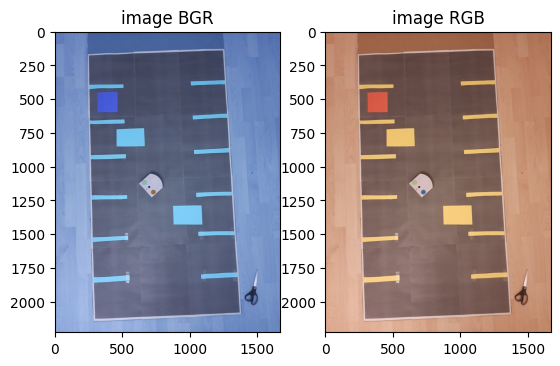

In [236]:
img_BGR = cv2.imread('test3.jpg', cv2.IMREAD_COLOR) # only works for test3.jpg, the color thresholds are incorrect otherwise, the size image for area detection also
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img_BGR, cmap='gray'), ax1.set_title('image BGR')
ax2.imshow(img_RGB, cmap='gray'), ax2.set_title('image RGB')
plt.show()

In [237]:
scale_percent = 30 #BE CAREFUL : area contour detection work at least between 30 and 80 scale_percent range

width = int(img_RGB.shape[1] * scale_percent / 100)
height = int(img_RGB.shape[0] * scale_percent / 100)
dsize = (width, height)
output = cv2.resize(img_RGB, dsize)
#plt.imshow(output), plt.show()

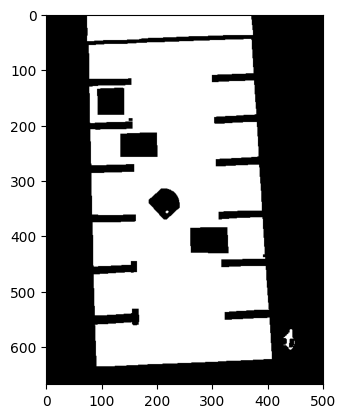

In [238]:
x0 = 170
lower_thld = np.array([0, 0, 0])
upper_thld = np.array([x0, x0, x0])

mask = cv2.inRange(output, lower_thld, upper_thld)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel)
plt.imshow(mask, cmap='gray')
plt.show()

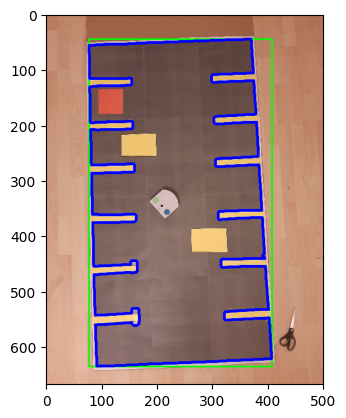

(<matplotlib.image.AxesImage at 0x1687dc7d0c0>, None)

In [239]:
test = output.copy()
test2 = output.copy()
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key = cv2.contourArea)

x,y,w,h = cv2.boundingRect(cnt)
cv2.rectangle(test,(x,y),(x+w,y+h),(0,255,0),2)
test = cv2.drawContours(test, [cnt] , -1, (0, 0, 255), 3)
plt.imshow(test), plt.show()

In [240]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    # Make sure contours array is 2d
    pts = np.squeeze(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

corners = order_points(cnt)

In [241]:
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)

destination_corners = find_dest(corners)

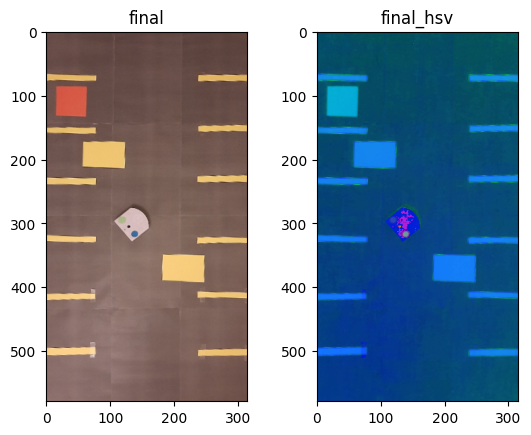

In [242]:
h, w = test2.shape[:2]
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(test2, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
#final image in hsv to work on 
final_hsv = final.copy()
final_hsv = cv2.cvtColor(final_hsv, cv2.COLOR_RGB2HSV)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(final, cmap='gray'), ax1.set_title('final')
ax2.imshow(final_hsv, cmap='gray'), ax2.set_title('final_hsv')
plt.show()
#area of the parking
parking_area= final_hsv.shape[0]*final_hsv.shape[1]
#ratio of the colr elements
red_square_ratio = 0.013        # the red_square    is 0.0123   of the parking area
green_circle_ratio = 0.00035    # the green_circle  is 0.00035  of the parking area
blue_circle_ratio = 0.000492    # the blue_circle   is 0.000492 of the parking area

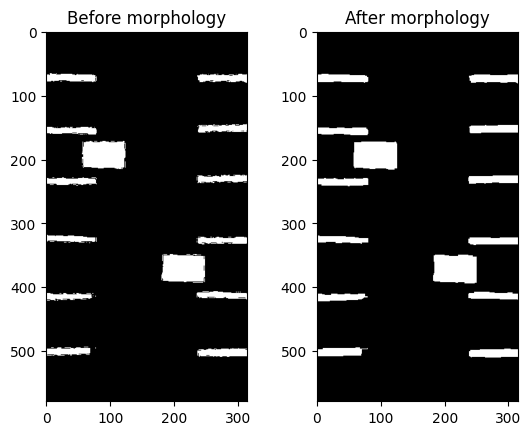

In [243]:
#copy of the hsv picture to work on the yellow
yellow_copy = final_hsv.copy()

lower_yellow = np.array([10, 100, 100])
upper_yellow = np.array([25, 255, 255])

mask_yellow = cv2.inRange(yellow_copy, lower_yellow, upper_yellow)
kernel = np.ones((10, 10), np.uint8)
mask_yellow2 = cv2.dilate(mask_yellow, kernel)
mask_yellow2 = cv2.erode(mask_yellow2, kernel)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mask_yellow, cmap='gray'), ax1.set_title('Before morphology')
ax2.imshow(mask_yellow2, cmap='gray'), ax2.set_title('After morphology')
plt.show()

red square centroid coordinate :
 cx: 39,  cy: 109


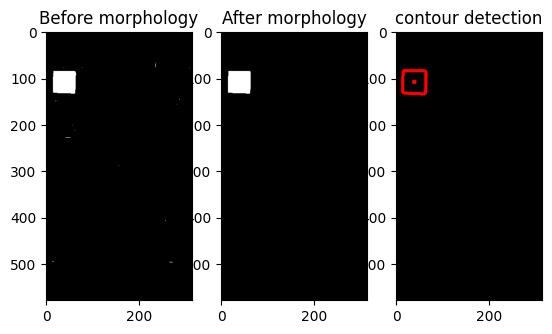

In [244]:
#copy of the hsv picture to work on the red square
red_copy = final_hsv.copy()
#red_mask1
lower_red = np.array([0,120,70])
upper_red = np.array([10,255,255])
mask_red1 = cv2.inRange(red_copy, lower_red, upper_red)
#cleening: red_mask2
kernel = np.ones((7, 7), np.uint8)
mask_red2 = cv2.erode(mask_red1, kernel)
mask_red2 = cv2.dilate(mask_red2, kernel)

#findcontours
ret, thresh = cv2.threshold(mask_red2, 200, 255,cv2.THRESH_BINARY_INV)
contours_red, hierarchies = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros(thresh.shape[:2],dtype='uint8')
#Get desired contour based on area
c_red_index = 0
cx_red = 0
cy_red = 0
for i, c in enumerate(contours_red):
    area = cv2.contourArea(c)
    if (area<red_square_ratio*parking_area*1.05)and(area>red_square_ratio*parking_area*0.95):
        #print(red_square_ratio*parking_area*0.95,   area,   red_square_ratio*parking_area*1.05)
        c_red_index = i
M = cv2.moments(contours_red[c_red_index]) #moment of selected contour
cx_red = int(M['m10'] / M['m00']) #Get centroid coordinates
cy_red = int(M['m01'] / M['m00'])
#drawContours
black = np.zeros_like(final)
cv2.drawContours(black, contours_red, c_red_index, (255, 0, 0), 5)
cv2.circle(black, (cx_red, cy_red), 5, (255, 0, 0), -1)
#Plot results
print(f"red square centroid coordinate :\n cx: {cx_red},  cy: {cy_red}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask_red1, cmap='gray'), ax1.set_title('Before morphology')
ax2.imshow(mask_red2,cmap='gray'), ax2.set_title('After morphology')
ax3.imshow(black,cmap='gray'), ax3.set_title('contour detection')
plt.show()

green circle centroid coordinate :
 cx: 118,  cy: 295



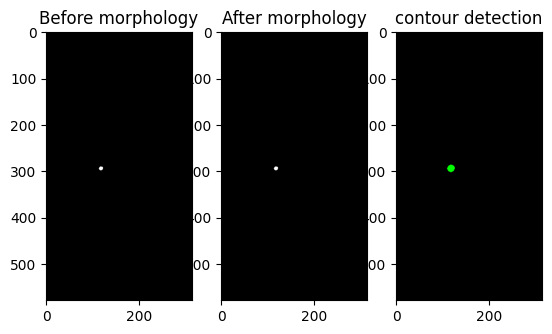

In [245]:
#copy of the hsv picture to work on green circle
green_copy = final_hsv.copy()
#green_mask1
lower_green = np.array([36, 25, 25])
upper_green = np.array([70, 255,255])
mask_green1 = cv2.inRange(green_copy, lower_green, upper_green)
#cleening: green_mask2
kernel = np.ones((7, 7), np.uint8)
mask_green2 = cv2.dilate(mask_green1, kernel)
mask_green2 = cv2.erode(mask_green2, kernel)
#findcontours
ret, thresh = cv2.threshold(mask_green2, 200, 255,cv2.THRESH_BINARY_INV)
contours_green, hierarchies = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros(thresh.shape[:2],dtype='uint8')
#Get desired contour based on area
c_green_index = 0
cx_green = 0
cy_green = 0
for i, c in enumerate(contours_green):
    area = cv2.contourArea(c)
    if (area<green_circle_ratio*parking_area*1.15)and(area>green_circle_ratio*parking_area*0.85):
        #print(green_circle_ratio*parking_area*0.95, area, green_circle_ratio*parking_area*1.05)
        c_green_index = i
M = cv2.moments(contours_green[c_green_index]) #moment of selected contour
cx_green = int(M['m10'] / M['m00']) #Get centroid coordinates
cy_green = int(M['m01'] / M['m00'])
#drawContours
black = np.zeros_like(final)
cv2.drawContours(black, contours_green, c_green_index, (0, 255, 0), 5)
cv2.circle(black, (cx_green, cy_green), 5, (0, 255, 0), -1)
#Plot results
print(f"green circle centroid coordinate :\n cx: {cx_green},  cy: {cy_green}\n")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask_green1, cmap='gray'), ax1.set_title('Before morphology')
ax2.imshow(mask_green2,cmap='gray'), ax2.set_title('After morphology')
ax3.imshow(black,cmap='gray'), ax3.set_title('contour detection')
plt.show()

blue circle centroid coordinate :
 cx: 137,  cy: 317



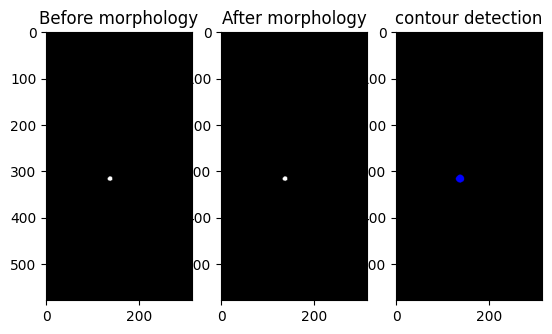

In [246]:
#copy of the hsv picture to work on the blue circle
blue_copy = final_hsv.copy()
#blue_mask1
lower_blue = np.array(color_dict_HSV["blue"][1])
upper_blue = np.array(color_dict_HSV["blue"][0])
mask_blue1 = cv2.inRange(blue_copy, lower_blue, upper_blue)
#cleening: red_mask2
kernel = np.ones((7, 7), np.uint8)
mask_blue2 = cv2.dilate(mask_blue1, kernel)
mask_blue2 = cv2.erode(mask_blue2, kernel)
#findcontours
ret, thresh = cv2.threshold(mask_blue2, 200, 255,cv2.THRESH_BINARY_INV)
contours_blue, hierarchies = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros(thresh.shape[:2],dtype='uint8')
#Get desired contour based on area
c_blue_index = 0
cx_blue = 0
cy_blue = 0
for i, c in enumerate(contours_blue):
    area = cv2.contourArea(c)
    if (area<blue_circle_ratio*parking_area*1.1)and(area>blue_circle_ratio*parking_area*0.9):
        #print(blue_circle_ratio*parking_area*0.90, area, blue_circle_ratio*parking_area*1.1)
        c_blue_index = i
M = cv2.moments(contours_blue[c_blue_index]) #moment of selected contour
cx_blue = int(M['m10'] / M['m00']) #Get centroid coordinates
cy_blue = int(M['m01'] / M['m00'])
#drawContours
black = np.zeros_like(final)
cv2.drawContours(black, contours_blue, c_blue_index, (0, 0, 255), 5)
cv2.circle(black, (cx_blue, cy_blue), 5, (0, 0, 255), -1)
#Plot results
print(f"blue circle centroid coordinate :\n cx: {cx_blue},  cy: {cy_blue}\n")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask_blue1, cmap='gray'), ax1.set_title('Before morphology')
ax2.imshow(mask_blue2,cmap='gray'), ax2.set_title('After morphology')
ax3.imshow(black,cmap='gray'), ax3.set_title('contour detection')
plt.show()

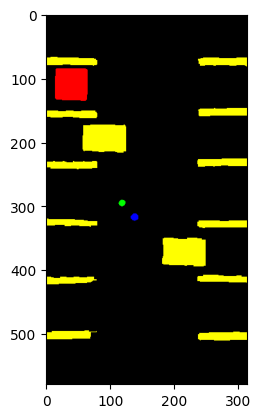

red square centroid coordinate :
 cx_red: 39,  cy_red: 109

blue circle centroid coordinate :
 cx_blue: 137,  cy_blue: 317

green circle centroid coordinate :
 cx_green: 118,  cy_green: 295



In [250]:
final_seg = np.zeros_like(final)

for i in range(final_seg.shape[0]):
    for j in range(final_seg.shape[1]):
        if mask_yellow2[i, j]:
            final_seg[i, j] = np.array([255, 255, 0])
cv2.drawContours(final_seg, contours_blue, c_blue_index, (0, 0, 255), -1) #-1 to fill the contour with color
cv2.drawContours(final_seg, contours_green, c_green_index, (0, 255, 0), -1) #-1 to fill the contour with color
cv2.drawContours(final_seg, contours_red, c_red_index, (255, 0, 0), -1) #-1 to fill the contour with color

cv2.imwrite('segmentation_colors.jpg', cv2.cvtColor(final_seg, cv2.COLOR_RGB2BGR))

plt.imshow(final_seg), plt.show()
print(f"red square centroid coordinate :\n cx_red: {cx_red},  cy_red: {cy_red}\n")
print(f"blue circle centroid coordinate :\n cx_blue: {cx_blue},  cy_blue: {cy_blue}\n")
print(f"green circle centroid coordinate :\n cx_green: {cx_green},  cy_green: {cy_green}\n")

In [293]:
#distance in mm
l_parkmm = 1600 #mm 
l_parkpix = final.shape[0] #pixel
r_PIX2MM = l_parkmm/l_parkpix
print(f'the ratio from pixel to mm is : {r_PIX2MM}')
#position of thymio
x_t = 0.5*(cx_blue+cx_green)
y_t = 0.5*(cy_blue+cy_green)
print(f'posiion of thymio is: x : {x_t*r_PIX2MM} mm and y : {y_t*r_PIX2MM} mm')
print(f'posiion of thymio is: x : {x_t} pix and y : {y_t} pix')
#angle of thymio :
theta = math.atan2((cy_blue-cy_green),(cx_blue-cx_green))
if (theta>math.pi):
    theta = theta-2*math.pi
print(theta*180/math.pi)


the ratio from pixel to mm is : 2.763385146804836
posiion of thymio is: x : 352.3316062176166 mm and y : 845.5958549222797 mm
posiion of thymio is: x : 127.5 pix and y : 306.0 pix
49.18491612511842


#resources : 

https://www.geeksforgeeks.org/python-opencv-find-center-of-contour/

https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208

https://medium.com/featurepreneur/draw-contours-on-an-image-using-opencv-186b67f87c92